In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from matplotlib import pyplot as plt
from astropy    import units

from common import hallmark as hm
from common import io_ipole as io
from common import viz
from common import dalt
from common import mockservation as ms

In [2]:
pf = hm.ParaFrame(
    'model/Illinois_thermal/230GHz/{mag}a{aspin:g}_w{window:d}/img_s{snapshot:d}_Rh{Rhigh:d}_i{inc:d}.h5'
)

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

Rhigh [10 40]
snapshot [5000 5001 5002 5003 5004 5005 5006 5007 5008 5009 5010 5011 5012 5013
 5014 5015]
window [5]
aspin [0.94]
mag ['S']
inc [50 70]


In [3]:
sel = pf(inc=70)
sel

,path,mag,aspin,window,snapshot,Rhigh,inc
1,model/Illinois_thermal/230GHz/Sa+0.94_w5/img_s...,S,0.94,5,5000,40,70
3,model/Illinois_thermal/230GHz/Sa+0.94_w5/img_s...,S,0.94,5,5001,40,70
5,model/Illinois_thermal/230GHz/Sa+0.94_w5/img_s...,S,0.94,5,5002,40,70
7,model/Illinois_thermal/230GHz/Sa+0.94_w5/img_s...,S,0.94,5,5003,40,70
9,model/Illinois_thermal/230GHz/Sa+0.94_w5/img_s...,S,0.94,5,5004,40,70
...,...,...,...,...,...,...,...
1991,model/Illinois_thermal/230GHz/Sa+0.94_w5/img_s...,S,0.94,5,5995,40,70
1993,model/Illinois_thermal/230GHz/Sa+0.94_w5/img_s...,S,0.94,5,5996,40,70
1995,model/Illinois_thermal/230GHz/Sa+0.94_w5/img_s...,S,0.94,5,5997,40,70
1997,model/Illinois_thermal/230GHz/Sa+0.94_w5/img_s...,S,0.94,5,5998,40,70


In [4]:
imgs = io.load_mov(sel[:100].path)

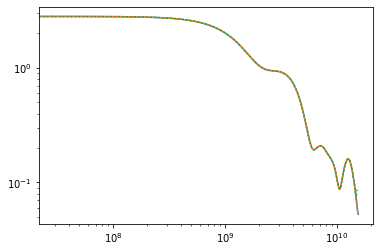

In [5]:
def mkplot(N=400, **kwargs):
    tmp = ms.compress(imgs, N=N)
    vis = ms.mockserve(tmp, [1024,1024])

    U = vis.uvd[0]
    U = np.linspace(-U/2,U/2,vis.shape[-2],endpoint=False)
    plt.loglog(U, abs(vis[0,:,0]), **kwargs)
    
mkplot(400)
mkplot(640,  linestyle='--')
mkplot(1280, linestyle=':')

In [6]:
from copy import copy
from math import ceil

def truncation_scale(tolerant=0.01, n=2):
    return (1/(tolerant*tolerant) - 1)**(0.5/n)

def compress(imgs, N=None, eht_f=15e9):
    meta = copy(imgs.meta)
    fov  = imgs.fov.to(units.rad).value
    
    spec, U, V = ms.upfft(imgs, *fov, N=N)
    
    u = np.linspace(-U/2,U/2,spec.shape[-2],endpoint=False)
    v = np.linspace( 0,  V/2,spec.shape[-1])
    u, v = np.meshgrid(u, v, indexing='ij')
    
    n  = 2
    rr = (u*u + v*v) / (eht_f*eht_f)
    Bw = 1 / np.sqrt(1 + rr**n)
    
    Nu =    spec.shape[-2]
    Nv = 2*(spec.shape[-1]-1)
    
    scale = truncation_scale(n=n)
    Ndown = [
        2 * ceil(abs(Nu * scale * eht_f / U / 2)),
        2 * ceil(abs(Nv * scale * eht_f / V / 2)),
    ]
    
    print(Bw.shape, spec.shape)
    
    print(Ndown)
    
    I, W, H = ms.downifft(spec * Bw[np.newaxis,:,:], U, V, N=Ndown)
    
    meta.width  = abs(W * meta.dist).to(meta.rg)
    meta.height = abs(H * meta.dist).to(meta.rg)
    return dalt.Image(I, meta=meta)

(400, 201) (100, 400, 201)
[146, 146]
(700, 351) (100, 700, 351)
[256, 256]
(1404, 703) (100, 1404, 703)
[512, 512]


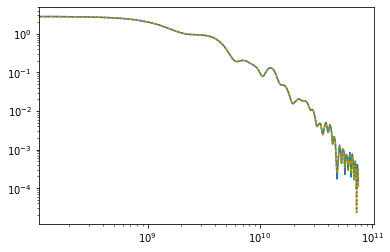

In [7]:
def mkplot(N=400, **kwargs):
    tmp = compress(imgs, N)
    vis = ms.mockserve(tmp, [1024,1024])

    U = vis.uvd[0]
    U = np.linspace(-U/2,U/2,vis.shape[-2],endpoint=False)
    plt.loglog(U, abs(vis[0,:,0]), **kwargs)
    
mkplot(400)
mkplot(700,  linestyle='--')
mkplot(1404, linestyle=':')

(700, 351) (100, 700, 351)
[256, 256]


<AxesSubplot:xlabel='Relative R.A. [$\\mathrm{\\mu as}$]', ylabel='Relative Declination [$\\mathrm{\\mu as}$]'>

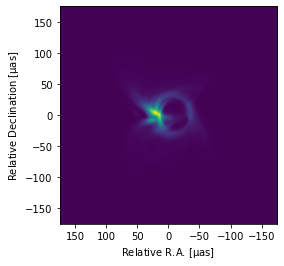

In [8]:
tmp = compress(imgs, 700)
viz.show(tmp, s=0)